In [142]:
import pandas as pd
from ipywidgets import widgets

In [232]:
data = pd.read_excel('verbali-esami.xls')
data.iloc[:10,3:8]

,Descrizione insegnamento,Cfu,Voto,Stato Esito,Data
0,PROGRAMMAZIONE II,6,19,Rifiutato,2021-02-24
1,PROGRAMMAZIONE II,6,20,Verbalizzato,2021-02-24
2,PROGRAMMAZIONE II,6,27,Verbalizzato,2021-02-24
3,PROGRAMMAZIONE II,6,20,Verbalizzato,2021-02-24
4,PROGRAMMAZIONE II,6,Respinto,Verbalizzato,2021-02-24
5,PROGRAMMAZIONE II,6,26,Verbalizzato,2021-02-24
6,PROGRAMMAZIONE II,6,20,Verbalizzato,2021-02-24
7,PROGRAMMAZIONE II,6,Ritirato,Verbalizzato,2021-02-23
8,PROGRAMMAZIONE II,6,Ritirato,Verbalizzato,2021-02-23
9,PROGRAMMAZIONE II,6,21,Verbalizzato,2021-02-23


In [503]:
insegnamenti = sorted(frozenset(data['Descrizione insegnamento']))
appelli = lambda insegnamento: sorted(frozenset(data[data['Descrizione insegnamento'] == insegnamento].Data.dt.date))
verbali = lambda insegnamento, appello: data[(data['Descrizione insegnamento'] == insegnamento) & (data.Data.dt.date == appello)]
starts_with_digit = lambda _: _[0] in frozenset('0123456789')
ends_with_digit = lambda _: _[-1] in frozenset('0123456789')
perc = lambda _: (10000*_/sum(_)).astype(int)/100
hist = lambda _: perc(_.value_counts()).sort_index().plot.bar()
count = lambda _: pd.DataFrame(_.value_counts().sort_index())

In [499]:
wins = widgets.Select(description = 'Insegnamenti')
wdate = widgets.SelectMultiple(description = 'Date')
wlabel = widgets.HTML(description = 'Selezione')

def uwdate(change):
    wdate.options = appelli(change.new)
    wdate.value = wdate.options
wins.observe(uwdate, names = 'value')

def uselected(change):
    global selected
    selected = data[(data['Descrizione insegnamento'] == wins.value) & (data.Data.dt.date.isin(wdate.value))]
    wlabel.value = "<b>Verbali</b>: {}<br/><b>Iscritti</b>: {}".format(len(selected), len(set(selected.Matricola)))
        
wdate.observe(uselected, names = 'value')    

wins.options = insegnamenti
wins.value = insegnamenti[0]
wdate.options = wdate.value = appelli(insegnamenti[0])

widgets.HBox([wins, wdate, wlabel])

In [521]:
def euniq(e):
    v = list(filter(starts_with_digit, e.values))
    if v: return v[0]
    v = list(filter(ends_with_digit, e.values))
    if v: return max(v)
    if 'Respinto' in e.values: return 'RE'
    if 'Ritirato' in e.values: return 'RI'
    
esiti_unici = (selected.apply(
    lambda r: pd.Series({'Matricola': r.Matricola, 'Esito': ('~' + r.Voto if r['Stato Esito'] == 'Rifiutato' else r.Voto)}), axis = 1
)[['Matricola', 'Esito']].groupby('Matricola').agg(euniq)).Esito

esiti_unici_sempl = esiti_unici.apply(
    lambda _: 'OK' if starts_with_digit(_) else ('~' if _[0] == '~' else _)
)

esiti_unici_promossi = esiti_unici[
    esiti_unici.apply(starts_with_digit)
].apply(
    lambda _: 33 if _ == '30 e lode' else int(_)
)

In [522]:
count(esiti_unici)

,Esito
18,9
19,6
20,8
21,4
22,5
23,3
24,4
25,2
26,2
27,2


In [523]:
count(esiti_unici_sempl)

,Esito
OK,56
RE,56
RI,23
~,1


<AxesSubplot:>

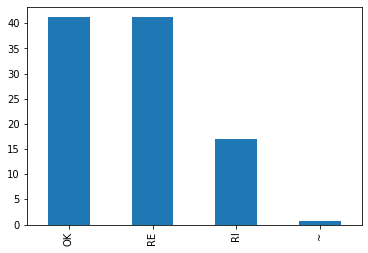

In [524]:
hist(esiti_unici_sempl)

<AxesSubplot:>

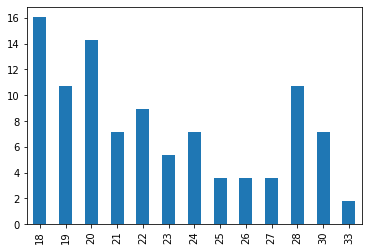

In [525]:
hist(esiti_unici_promossi)

In [496]:
def emerge(e):
    res = []
    for v in e.values:
        if starts_with_digit(v) or ends_with_digit(v): res.append(v)
        if v == 'Respinto': res.append('RE')
        if v == 'Ritirato': res.append('RI')
    return tuple(res)

patterns = selected.sort_values('Data').apply(
    lambda r: pd.Series({'Matricola': r.Matricola, 'Esito': ('~' + r.Voto if r['Stato Esito'] == 'Rifiutato' else r.Voto)}), axis = 1
).groupby('Matricola').agg(emerge)

patterns_len = patterns[patterns.Esito.apply(lambda _: starts_with_digit(_[-1]))].Esito.apply(len)

<AxesSubplot:>

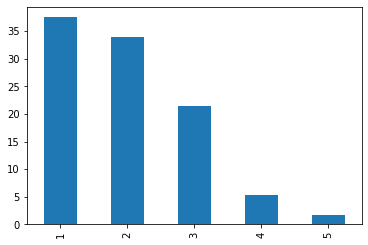

In [526]:
hist(patterns_len)

In [530]:
count(patterns)

,0
Esito,
"(18,)",2
"(19,)",2
"(20,)",2
"(21,)",1
"(22,)",3
"(23,)",2
"(24,)",2
"(26,)",1
"(28,)",2
